In [1]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver

from funcoes_auxiliares.funcoes_auxiliares import search_and_incorporate
# Add nodes
graph_builder = StateGraph(MessagesState)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain_groq import ChatGroq
#from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import List
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from funcoes_auxiliares.funcoes_auxiliares import search_and_incorporate

load_dotenv()
def chat_bot(mensagem):
    
    model = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
    )
    
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template("""
                                                      You are a chatbot specialized in movie recommendations for WhatsApp. Respond only to questions related to movie suggestions.

                                                        Behavior:
                                                        If the user greets you, greet them back; otherwise, respond only to the user's question.

                                                        Recommendations:
                                                        Always provide up to 5 movie suggestions with a brief summary of each. You receive internet search data about the subject requested by the user and should use this data to base your responses.
                                                        You are a chatbot specialized in movie recommendations for WhatsApp. Respond only to questions related to movie suggestions.
                                                        
                                                        
                                                        Restrictions:
                                                        Respond only if the user initiates contact. If the user neither greets nor asks a question, do not respond.
                                                        If the user asks where they can watch a movie, Just indicate where the movie is available without recommending another movie.

                                                        Final Note: Provide all responses in Portuguese.
                                                      """),
            HumanMessagePromptTemplate.from_template("{input}")
        ]
    )
    
    llm_chain = prompt | model| StrOutputParser()
    
    resposta = llm_chain.invoke([{"role": "user", "content": mensagem}])
    
    return {"messages": [{"role": "assistant", "content": resposta}]}
    

In [3]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chatbot", chat_bot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

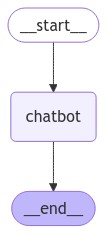

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
config = {"configurable": {"thread_id": "foo"}}
mensagem = 'Ola tudo bem?'
resposta = graph.invoke({"messages": [("user", mensagem)]}, config= config )

In [6]:
resposta

{'messages': [HumanMessage(content='Ola tudo bem?', additional_kwargs={}, response_metadata={}, id='ca481efb-a733-4628-98a4-4d98071a7ed9'),
  AIMessage(content='Olá, tudo bem! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar?', additional_kwargs={}, response_metadata={}, id='9d46b9ba-e618-4be5-8cec-63e5f0711c82')]}

In [7]:
config

{'configurable': {'thread_id': 'foo'}}

In [8]:
mensagem = 'gostaria de ver um filme de comedia'
resposta = graph.invoke({"messages": [("user", mensagem)]}, config= config )

In [9]:
resposta

{'messages': [HumanMessage(content='Ola tudo bem?', additional_kwargs={}, response_metadata={}, id='ca481efb-a733-4628-98a4-4d98071a7ed9'),
  AIMessage(content='Olá, tudo bem! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar?', additional_kwargs={}, response_metadata={}, id='9d46b9ba-e618-4be5-8cec-63e5f0711c82'),
  HumanMessage(content='gostaria de ver um filme de comedia', additional_kwargs={}, response_metadata={}, id='80d8816b-98c3-44d4-93ca-9e8df02d0d28'),
  AIMessage(content='Olá, tudo bem! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar? \n\nVocê gostaria de ver um filme de comédia, né? Aqui estão algumas sugestões:\n\n1. **Os Incríveis** (2004) - Uma história sobre uma família de super-heróis que tentam proteger a cidade de um vilão.\n2. **O Grande Lebowski** (1998) - Uma comédia sobre um homem que se torna um detetive para resolver um mistério envolvendo uma pintura de arte.\n3. **A Maldição do Drácula** (2004) - Uma comédia de terror sobre u

In [10]:
mensagem = 'Me indique filmes de comedia'
resposta = graph.invoke({"messages": [("user", mensagem)]}, config= config )

In [11]:
[msg.content for msg in resposta['messages']]

['Ola tudo bem?',
 'Olá, tudo bem! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar?',
 'gostaria de ver um filme de comedia',
 'Olá, tudo bem! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar? \n\nVocê gostaria de ver um filme de comédia, né? Aqui estão algumas sugestões:\n\n1. **Os Incríveis** (2004) - Uma história sobre uma família de super-heróis que tentam proteger a cidade de um vilão.\n2. **O Grande Lebowski** (1998) - Uma comédia sobre um homem que se torna um detetive para resolver um mistério envolvendo uma pintura de arte.\n3. **A Maldição do Drácula** (2004) - Uma comédia de terror sobre um homem que se torna o novo Drácula e tenta viver uma vida normal.\n4. **Superbad** (2007) - Uma comédia sobre dois amigos que tentam comprar álcool para uma festa de formatura.\n5. **O Grande Golpe** (2003) - Uma comédia sobre dois irmãos que tentam roubar um banco.\n\nEspero que essas sugestões sejam úteis!',
 'Me indique filmes de comedia',
 'Olá! Estou

In [12]:
resposta['messages'][-1].content

'Olá! Estou aqui para ajudar com sugestões de filmes. Como posso ajudar?'

# Adcionando search_and_incorporate ao graph

In [13]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver

from langchain_groq import ChatGroq
#from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import List
import os
from dotenv import load_dotenv
#from funcoes_auxiliares import search_and_incorporate
from extracao.extracao_textos_links_firacrawl import LinksExtractorFireCrawl
from langchain_community.tools import TavilySearchResults


load_dotenv()

def search_and_incorporate(user_input):
    # Realizando a pesquisa
     
    """
    Performs a search based on the user input, filters the search results,
    extracts and cleans the text from the filtered URLs, and combines the
    cleaned text with the original user input to produce a final output.

    Args:
        user_input (str): The input query from the user.

    Returns:
        str: The combined string of the original user input and the cleaned
        text extracted from the filtered search results.
    """
    user_input = user_input['messages'][-1].content
    
    search_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False)
    
    pesquisa = search_tool.invoke({"query": user_input})

    links = []
    
    for numero in range(len(pesquisa)):
        links.append(pesquisa[numero]['url'])
        
    # Filtrando resultados para remover links do YouTube
    links_results = [result for result in links if "youtube.com" not in result]


    extractor = LinksExtractorFireCrawl()
    
    texto = []
    
    for link in links_results:
        texto.append(extractor.clean_text_firecrawl(link))
        
    if isinstance(texto, list):
        texto = "\n".join(texto)
    
    combined_input = user_input + texto
    
    return {"messages": [("user", combined_input)]}


def chat_bot(mensagem):
    
    model = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
    )
    
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template("""
                                                      You are a chatbot specialized in movie recommendations for WhatsApp. Respond only to questions related to movie suggestions.

                                                        Behavior:
                                                        If the user greets you, greet them back; otherwise, respond only to the user's question.

                                                        Recommendations:
                                                        Always provide up to 5 movie suggestions with a brief summary of each. You receive internet search data about the subject requested by the user and should use this data to base your responses.
                                                        You are a chatbot specialized in movie recommendations for WhatsApp. Respond only to questions related to movie suggestions.
                                                        
                                                        
                                                        Restrictions:
                                                        Respond only if the user initiates contact. If the user neither greets nor asks a question, do not respond.
                                                        If the user asks where they can watch a movie, Just indicate where the movie is available without recommending another movie.

                                                        Final Note: Provide all responses in Portuguese.
                                                      """),
            HumanMessagePromptTemplate.from_template("{input}")
        ]
    )
    
    llm_chain = prompt | model| StrOutputParser()
    
    resposta = llm_chain.invoke([{"role": "user", "content": mensagem}])
    
    return {"messages": [{"role": "assistant", "content": resposta}]}


# Add nodes
graph_builder = StateGraph(MessagesState)



c:\Users\jefer\Documents\Ciencia de dados\LLMs\Movies-bot-llm\env\Lib\site-packages\pydantic\_internal\_fields.py:172: UserWarning: Field name "schema" in "FirecrawlApp.ExtractParams" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [14]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("search_and_incorporate", search_and_incorporate)
graph_builder.add_node("chatbot", chat_bot)
graph_builder.add_edge(START, "search_and_incorporate")
graph_builder.add_edge("search_and_incorporate", "chatbot")
graph_builder.add_edge("chatbot", END)
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

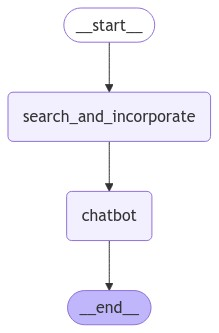

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
"""config = {"configurable": {"thread_id": "foo"}}
mensagem = 'Ola tudo bem?'
resposta = graph.invoke( {"messages": [("user", mensagem)]}, config= config )
men = {"messages": [("user", mensagem)]}
men['messages'][0][-1]"""

# Adcionando condicional

In [17]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver

from langchain_groq import ChatGroq
#from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import List
import os
from dotenv import load_dotenv
#from funcoes_auxiliares import search_and_incorporate
from extracao.extracao_textos_links_firacrawl import LinksExtractorFireCrawl
from extracao.extracao_textos_links_crawl4ai import LinksExtractor
from langchain_community.tools import TavilySearchResults
import random

load_dotenv()

from langchain_core.tools import tool

@tool
def search_and_incorporate(user_input):
    # Realizando a pesquisa
     
    """
    Performs a search based on the user input, filters the search results,
    extracts and cleans the text from the filtered URLs, and combines the
    cleaned text with the original user input to produce a final output.

    Args:
        user_input (str): The input query from the user.

    Returns:
        str: The combined string of the original user input and the cleaned
        text extracted from the filtered search results.
    """
    
    search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False)
    
    pesquisa = search_tool.invoke({"query": user_input})

    links = []
    
    for numero in range(len(pesquisa)):
        links.append(pesquisa[numero]['url'])
        
    # Filtrando resultados para remover links do YouTube
    links_results = [result for result in links if "youtube.com" not in result]


    #extractor = LinksExtractorFireCrawl()
    extractor = LinksExtractor()
    
    texto = []
    
    for link in links_results:
        #texto.append(extractor.clean_text_firecrawl(link))
        texto.append(extractor.clean_text(link))
        
    if isinstance(texto, list):
        texto = "\n".join(texto)
        
    texto_final = user_input + "\n\n" + texto
    
    
    return {"messages": [("user", texto_final)]}

            

def chat_bot(mensagem: str = None, 
             ):
    
    model = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
    )
    
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template("""
                                                      You are a chatbot specializing in recommending movies to users.
                                                            When a user requests a recommendation, use your tool of name {{search_and_incorporate}} to search for up-to-date information on the internet and provide the best movie suggestions.
                                                            If the user asks for recommendations to watch, always provide up to 5 movie suggestions, each accompanied by a brief summary highlighting the genre, plot, and reasons why the movie might be interesting.

                                                            Rules:
                                                            Respond only when requested: Only reply if the user greets you or asks for a recommendation.
                                                            Where to watch? If the user asks where a movie is available, provide only the platform or location. Do not include additional recommendations.
                                                            Language and tone: All responses should be written in Portuguese with a friendly and professional tone.
                                                            Objective:
                                                            Assist users with personalized movie recommendations, ensuring suggestions are based on accurate and recent information, and focus on enhancing their experience.

                                                            Example:
                                                            User: "Can you recommend a suspense movie?"
                                                            Chatbot:
                                                            Of course! Here are a few suggestions:
                                                            🎬 Split (2016): A psychological thriller about a man with multiple personalities who kidnaps three teenagers. Available on Prime Video.
                                                            🎥 The Silence of the Lambs (1991): A classic about an FBI trainee seeking help from a manipulative serial killer.
                                                            ...

                                                            Limitations:
                                                            Do not respond to questions unrelated to movies.
                                                            Be concise, relevant, and avoid unnecessary details.
                                                            Never repeat movies: If you’ve already mentioned a movie in the same conversation, do not suggest it again.
                                                      """),
            HumanMessagePromptTemplate.from_template("{input}"),
        ]
    )
    
    llm_chain = prompt | model| StrOutputParser()
    
    
    resposta = llm_chain.invoke([{"role": "user", "content": mensagem}])
    
    return {"messages": [("assistant", resposta)]}


def condicional_edges(state):
    
    last_message = state["messages"][-1].content.lower()
        
    lista_mensagens = ["filme", 
                        "recomendação", 
                        "sugestão", "assistir", 
                        "qual filme", 
                        "me fale um filme", 
                        "indique um filme", 
                        "onde assistir",
                        "gênero"]
        
        # Condicionais para verificar se a mensagem requer uma busca
    if any(keyword in last_message for keyword in lista_mensagens):
        input_incorporado = search_and_incorporate(last_message)
        if len(input_incorporado) > 6500:
            
            lenght_text = len(input_incorporado)
            
            indice_inicial = random.randint(0, lenght_text-6500)
            
            indice_final = indice_inicial + 6500
            
            input_incorporado = input_incorporado[indice_inicial:indice_final]
                        
    else:
        return state


In [ ]:
last_message = 'gostaria de ver um filme de suspense'
        
lista_mensagens = ["filme", 
                        "recomendação", 
                        "sugestão", "assistir", 
                        "qual filme", 
                        "me fale um filme", 
                        "indique um filme", 
                        "onde assistir",
                        "gênero"]
        
        # Condicionais para verificar se a mensagem requer uma busca
if any(keyword in last_message for keyword in lista_mensagens):
    input_incorporado = search_and_incorporate(last_message)
    if len(input_incorporado) > 6500:
            
        lenght_text = len(input_incorporado)
            
        indice_inicial = random.randint(0, lenght_text-6500)
            
        indice_final = indice_inicial + 6500
            
        input_incorporado = input_incorporado[indice_inicial:indice_final]

In [ ]:
input_incorporado['messages'][0][1]

In [ ]:
type(input_incorporado)

In [ ]:
len(input_incorporado['messages'][0][1])

In [ ]:
if len(input_incorporado['messages'][0][1]) > 6500:
    print("sim")

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chat_bot", chat_bot)
graph_builder.add_node("conditional_edges", condicional_edges)
graph_builder.add_edge("conditional_edges", "chat_bot")
graph_builder.add_edge(START, "conditional_edges")
graph_builder.add_edge("chat_bot", END)
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
)
user_input = "ola tudo bem, meu nome e jeferson?"

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke({"messages": [("user", user_input)]}, config)

In [ ]:
user_input = "vc sabe o meu nome"

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke({"messages": [("user", user_input)]}, config)

In [ ]:
user_input = "Gostaria de um filme de fantasia"

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke({"messages": [("user", user_input)]}, config)

In [ ]:
user_input = "Gostaria de um filme de comedia na netflix"

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke({"messages": [("user", user_input)]}, config)

In [ ]:
user_input = "Meu nome e jeferson"

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke({"messages": [("user", user_input)]}, config)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Scraping com Html2Text

In [1]:
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers.html2text import Html2TextTransformer
loader = AsyncHtmlLoader(['https://www.adorocinema.com/filmes/melhores/genero-13005/'])
docs = loader.load()
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)
doc_transformed = docs_transformed[0]

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.12it/s]


In [2]:
from construindo_langGraph import graph_invoke
from langgraph.checkpoint.memory import MemorySaver

In [3]:
memory_saver = MemorySaver()
config = {"configurable": {"thread_id": "foo"}}
message = 'Me indique filmes de comedia antigos'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:03<00:00,  3.52s/it]


{'messages': [('user', 'me indique filmes de comedia antigos\nArthur Bach é um playboy milionário de vida boa completamente sem rumo que mora em Nova York. Sua família está disposta a negar sua herança caso não se case com sua namorada insuportável em menos de um mês. Para completar o leque de problemas, é por Linda Marolla, uma garçonete do Queens, por quem Arthur é apaixonado.\n\nEm um dos melhores filmes de comédia de todos os tempos, o ator nova-iorquino Michael Dorsey é talentoso, porém muito perfeccionista e duro consigo mesmo e com os outros. Isso faz com que seu agente tenha dificuldade de encontrar trabalho para Michael. Depois de fracassar em um teste de novela, Michael resolve se transformar na atriz Dorothy e finalmente consegue o papel.\n\nTítulo original: _Fast Times at Ridgemont High_\nStacy Hamilton é uma adolescente extremamente bonita pronta para namorar – mas sem experiência nenhuma. Com a ajuda de sua amiga desinibida, Linda Barrett, Stacy entra em um triângulo amor

['Olá! Estou aqui para ajudar com filmes de comédia antigos. Você mencionou vários títulos interessantes, incluindo "Arthur", "Tootsie", "Fast Times at Ridgemont High", "National Lampoon\'s Vacation", "Trading Places", "Beverly Hills Cop", "Ghostbusters", "This Is Spinal Tap", "Pee-wee\'s Big Adventure", "Lost in America" e "Curtindo a Vida Adoidado" (também conhecido como "Ferris Bueller\'s Day Off").',
 '',
 'Se você está procurando por mais sugestões de filmes de comédia antigos, aqui estão cinco opções adicionais:',
 '',
 '1. **Planes, Trains and Automobiles** (1987) - Um clássico de comédia com Steve Martin e John Candy como dois viajantes que tentam chegar em casa para o Dia de Ação de Graças.',
 '2. **Caddyshack** (1980) - Uma comédia clássica sobre um grupo de golfistas e seus caddies em um clube de golfe.',
 '3. **The Blues Brothers** (1980) - Uma comédia musical com John Belushi e Dan Aykroyd como dois irmãos que tentam reunir sua antiga banda de blues.',
 "4. **National Lamp

In [4]:
config = {"configurable": {"thread_id": "foo"}}
message = 'Me indique filmes de comedia antigos brasileiros'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


{'messages': [('user', 'me indique filmes de comedia antigos\nAqui está o texto extraído do Markdown, sem formatação, links, imagens ou outros elementos irrelevantes:\n\nA massagista Eva é uma mulher divorciada e mãe solteira que teme a partida da sua filha para a faculdade. Ela logo começa um romance com Albert, um homem engraçado que está vivendo um momento muito parecido com o seu. Porém, esse relacionamento será ameaçado com a chegada de sua nova cliente, Marianne, que se torna sua amiga, mas também é ex-mulher de Albert.\n\nEmmet é uma minifigura LEGO perfeitamente comum e seguidora das regras, que é erroneamente identificada como uma pessoa extraordinária, essencial para salvar o mundo. Ele é recrutado por uma irmandade de estranhos para uma jornada épica com a finalidade de deter um tirano, uma viagem para a qual Emmet está totalmente despreparado.\n\nNa década de 1930, o gerente de um famoso hotel europeu se torna muito amigo de um jovem companheiro de trabalho. Os dois acabam 

['Olá! Estou aqui para ajudar com filmes de comédia antigos brasileiros. Aqui estão cinco opções adicionais:',
 '',
 '1. **A Princesa Xuxa e os Trapalhões** (1989) - Um filme de comédia clássico com a participação de Xuxa e os Trapalhões.',
 '2. **Os Trapalhões na Serra Pelada** (1982) - Outro filme de comédia com os Trapalhões, ambientado na Serra Pelada.',
 '3. **A Grande Família: O Filme** (2007) - Uma adaptação cinematográfica da série de TV "A Grande Família", com um elenco talentoso.',
 '4. **Cazuza - O Tempo Não Pára** (2006) - Um filme biográfico sobre a vida do cantor Cazuza, com elementos de comédia.',
 '5. **Tropa de Elite** (2007) - Um filme de comédia e ação que segue a história de um grupo de policiais no Rio de Janeiro.',
 '',
 'Esses filmes são todos considerados clássicos da comédia brasileira e são garantidos para fazer você rir. Qual deles você gostaria de saber mais sobre?']

In [5]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Onde eu posso assistir O Auto da Compadecida'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 11.89it/s]


{'messages': [('user', 'me indique filmes de comedia antigos\n### 43. _O Gosto dos Outros_ (2000)\nNotas da crítica: 100%\nCastella, um homem de negócios bem-sucedido, contrata Clara, uma atriz que foi sua professora de inglês no passado. Enquanto isso, Manie, uma amiga de Clara, é uma garçonete que faz tráfico de haxixe.\n\n### 42. _A Fuga das Galinhas_ (2000)\nNotas da crítica: 97%\nGalinhas cumprem sua função em uma fazenda inglesa dos anos 1950, sonhando com uma vida melhor. Uma delas, Ginger, planeja sair voando dali junto com suas companheiras.\n\n### 41. _Monstros S.A._ (2001)\nNotas da crítica: 96%\nJames Sullivan e seu assistente Mike são os principais monstros da maior fábrica de monstros do mundo. Eles conhecem uma garotinha chamada Boo e precisam assustá-la.\n\n### 40. _O Homem Sem Passado_ (2002)\nNotas da crítica: 98%\nUm homem perde a memória após ser surrado brutalmente. Ele começa a viver como pode no submundo da cidade, onde encontra pessoas como ele que são deserdada

['Olá! Estou aqui para ajudar com filmes de comédia antigos brasileiros. Você mencionou que gostaria de saber onde assistir "O Auto da Compadecida". Infelizmente, não tenho acesso a informações sobre a disponibilidade de filmes em plataformas de streaming específicas. No entanto, posso sugerir algumas opções de filmes de comédia antigos brasileiros que você pode gostar:',
 '',
 '1. **A Princesa Xuxa e os Trapalhões** (1989) - Um filme de comédia clássico com a participação de Xuxa e os Trapalhões.',
 '2. **Os Trapalhões na Serra Pelada** (1982) - Outro filme de comédia com os Trapalhões, ambientado na Serra Pelada.',
 '3. **A Grande Família: O Filme** (2007) - Uma adaptação cinematográfica da série de TV "A Grande Família", com um elenco talentoso.',
 '4. **Cazuza - O Tempo Não Pára** (2006) - Um filme biográfico sobre a vida do cantor Cazuza, com elementos de comédia.',
 '5. **Tropa de Elite** (2007) - Um filme de comédia e ação que segue a história de um grupo de policiais no Rio de 

In [6]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Onde eu posso assistir O Auto da Compadecida'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 11.07it/s]


{'messages': [('user', 'me indique filmes de comedia antigos\nNunca Fui Beijada (1999)\nJosie Geller, uma jornalista de 25 anos, é incumbida de fazer uma matéria sobre a vida do meio estudantil. Para ter sucesso, Josie terá que voltar a ser uma estudante e se infiltrar numa turma do seu antigo colegio.\n\n2 Dias em Paris (2007)\nMarion e Jack são um casal que resolve fazer uma viagem romantica para Veneza e, antes de regressarem aos EUA, fazem uma parada de dois dias em Paris. Mas, 48 horas são mais do que suficientes para despertar incertezas sobre a natureza do que Marion e Jack sentem um pelo outro.\n\nEnquanto Voce Dormia (1995)\nA comedia romantica conta a historia de Lucy, uma funcionaria solitaria do metro. Ela salva a vida de um homem chamado Peter Callaghan de um acidente e é confundida como sua noiva quando ele entra em coma.\n\nO Melhor Amigo da Noiva (2008)\nTom e Hanna são melhores amigos desde a época da universidade. Quando Hanna é pedida em casamento por Colin, Tom subi

['Olá! Estou aqui para ajudar com filmes de comédia antigos brasileiros. Você mencionou "O Auto da Compadecida" e perguntou onde assisti-lo. Infelizmente, não tenho acesso a informações sobre a disponibilidade de filmes em plataformas de streaming específicas. No entanto, posso sugerir que você procure por "O Auto da Compadecida" na plataforma Netflix. Se não estiver disponível, você também pode procurar em outras plataformas como Amazon Prime Video ou Google Play Filmes. ',
 '',
 'Além disso, aqui estão cinco opções adicionais de filmes de comédia antigos brasileiros que você pode gostar:',
 '',
 '1. **A Princesa Xuxa e os Trapalhões** (1989) - Um filme de comédia clássico com a participação de Xuxa e os Trapalhões.',
 '2. **Os Trapalhões na Serra Pelada** (1982) - Outro filme de comédia com os Trapalhões, ambientado na Serra Pelada.',
 '3. **A Grande Família: O Filme** (2007) - Uma adaptação cinematográfica da série de TV "A Grande Família", com um elenco talentoso.',
 '4. **Cazuza -

In [7]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Me descreva o filme O Auto da Compadecida'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.68it/s]


{'messages': [('user', 'me indique filmes de comedia antigos\n**Melhores Filmes de Comédia para Assistir em 2023**\n==============================\n\n1.  **Monty Python em Busca do Cálice Sagrado**\n    *   Comédia britânica de 1975\n    *   Direção de Terry Gilliam e Terry Jones\n    *   Ambientado na Idade Média, o filme satiriza eventos históricos\n    *   Estrelado por todos os integrantes do grupo de comédia Monty Python\n    *   Disponível na Netflix, com 96% de aprovação da crítica no Rotten Tomatoes e nota 8,2 do público no IMDb\n\n2.  **Missão Madrinha de Casamento**\n    *   Escrito por Annie Mumolo e Kristen Wiig\n    *   Dirigido por Paul Feig\n    *   Kristen interpreta uma mulher em um momento problemático da vida\n    *   Disponível no Lionsgate+ e Claro TV+, com 89% de aprovação da crítica no Rotten Tomatoes e nota 6,8 dos usuários do IMDb\n\n3.  **Noivo Neurótico, Noiva Nervosa**\n    *   Clássico de Woody Allen\n    *   Comédia romântica de 1977\n    *   Protagonizado

['Olá! Estou aqui para ajudar com filmes de comédia antigos. Você mencionou "O Auto da Compadecida" e perguntou sobre ele. "O Auto da Compadecida" é um filme brasileiro de 2000, dirigido por Guel Arraes e baseado na peça de teatro de Ariano Suassuna. O filme é uma comédia que conta a história de dois amigos, Chicó e João Grilo, que vivem em um pequeno vilarejo no Nordeste do Brasil. Eles são conhecidos por suas trapalhadas e golpes, mas sempre acabam se metendo em problemas.',
 '',
 'Agora, se você está procurando por onde assistir "O Auto da Compadecida", posso sugerir que você procure na plataforma Netflix. Se não estiver disponível, você também pode procurar em outras plataformas como Amazon Prime Video ou Google Play Filmes.',
 '',
 'Além disso, aqui estão cinco opções adicionais de filmes de comédia antigos brasileiros que você pode gostar:',
 '',
 '1. **A Princesa Xuxa e os Trapalhões** (1989) - Um filme de comédia clássico com a participação de Xuxa e os Trapalhões.',
 '2. **Os 

In [ ]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Quais filmes estao no cimena na data de dezembro de 2024'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

In [ ]:

config = {"configurable": {"thread_id": "foo"}}
message = 'E quais filmes estream na netflix na data de dezembro de 2024'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

In [ ]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Me descreva sobre a serie Churchill em Guerra'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.90it/s]


{'messages': [('user', 'e quais filmes estream na netflix na data de dezembro de 2024\nConfira todos os lançamentos de filmes e séries na Netflix em dezembro! \n\nO último mês de 2024 promete agitar a Netflix com uma programação repleta de grandes estreias e retornos aguardados.\n\nEntre os destaques estão a chegada da segunda temporada de "Round 6", a adaptação de "Cem Anos de Solidão", e novos episódios de sucessos como "Virgin River" e "Queer Eye". No cinema, lançamentos como "Homem-Aranha: Longe de Casa", a franquia "Transformers" e um especial natalino estrelado por Sabrina Carpenter.\n\n## Lançamentos da Netflix em dezembro 2024\n\n* Homem-Aranha: Longe de Casa | 01/12/2024\n* Taxi Driver | 01/12/2024\n* Transformers | 01/12/2024\n* Transformers: O Lado Oculto da Lua | 01/12/2024\n* Transformers: O Último Cavaleiro | 01/12/2024\n* Transformers: A Era da Extinção | 01/12/2024\n* Transformers: A Vingança dos Derrotados | 01/12/2024\n* Bumblebee | 01/12/2024\n* O Amor Não Tira Féria

['Olá! Estou aqui para ajudar com suas dúvidas sobre filmes e séries.',
 '',
 'Parece que você está procurando por informações sobre os lançamentos da Netflix em dezembro de 2024. Aqui estão alguns dos filmes e séries que entrarão na Netflix em dezembro:',
 '',
 '**Filmes:**',
 '',
 '* Homem-Aranha: Longe de Casa',
 '* Taxi Driver',
 '* Transformers',
 '* Ghostbusters: Mais Além',
 '* Bob Marley: One Love',
 '* A Nonsense Christmas with Sabrina Carpenter',
 '* Tropa de Elite',
 '',
 '**Séries:**',
 '',
 '* O Ultimato: Ou Casa ou Vaza',
 '* Black Doves',
 '* O Show da Luna!: Temporada 4',
 '* Rugby: Vencer ou Morrer',
 '* Cem Anos de Solidão: Parte 1',
 '* Queer Eye: Temporada 9',
 '* Quem Vê Casa…',
 '* A Culpa é do Cabral: Temporadas 11-12',
 '* Parenthood: Temporada 1',
 '* Virgin River: Temporada 6',
 '* Round 6 - Temporada 2',
 '',
 'Além disso, você também perguntou sobre a série "Churchill em Guerra", mas não há informações sobre essa série nos dados que eu tenho. Se você tiver m

In [ ]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Onde eu posso assistir a serie Churchill em Guerra'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.50s/it]


{'messages': [('user', "onde eu posso assistir a serie churchill em guerra\nChurchill na Guerra\n================\n\n### Sinopse\n\nEsta cativante série documental analisa o papel fundamental de Winston Churchill na 2.ª Guerra Mundial e os eventos que fizeram dele o líder ideal para uma era.\n\n### Gêneros\n\n- Documentário\n- História\n- Guerra & Militar\n\n### Temporadas\n\n- 1 Temporada, 4 Episódios\n\n### Episódios\n\n1. **T1 Ep1 - Tempesta em arrivo**: Spinto dalla determinação a salvare la Gran Bretagna fin dall'infanzia, Churchill si fa strada da soldato a Primo ministro enquanto incombe la minaccia delle forze tedesche.\n2. **T1 Ep2 - O seu melhor momento**: Da Primo ministro e Ministro della difesa, Churchill mobilita a nação com discursos volti ad attirare il sostegno degli Stati Uniti mentre Hitler lancia il Blitz su Londra.\n3. **T1 Ep3 - O dia do destino**: Gli sforzi indefessi di Churchill portano all'entrata in guerra degli Stati Uniti, ma per sconfiggere la Germania naz

['A série "Churchill em Guerra" está disponível na plataforma Netflix. Se você tiver interesse em assistir a outros documentários ou séries sobre história ou guerra, posso sugerir algumas opções. Você gostaria de algumas recomendações?']

In [ ]:

config = {"configurable": {"thread_id": "foo"}}
message = 'Onde eu posso assistir Churchill: O Último Leão'
response = graph_invoke(message, config, memory_saver)
response.split('\n')

In [10]:
from funcoes_auxiliares.funcoes_auxiliares import search_and_incorporate,condicional_edges

In [12]:
input = {"messages": [{"content": "qual filme estao no cinema na data de dezembro de 2024"}]}
condicional_edges(input)

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.71it/s]


{'messages': [('user', 'qual filme estao no cinema na data de dezembro de 2024\nO Senhor dos Anéis: A Guerra dos Rohirrim\nLogo no início de dezembro, é hora de os fãs das obras de J.R.R. Tolkien retornarem ao incrível universo de _O Senhor dos Anéis_ com o filme animado _O Senhor dos Anéis: A Guerra dos Rohirrim_. "Em Rohan, um ataque surpresa de Wulf, um senhor Dunlendino astuto e implacável em busca de vingança pela morte de seu pai, força o rei Helm Mão-de-Martelo e seu povo a fazerem uma última resistência ousada na antiga fortaleza de Hornburg", diz a sinopse.\n\nChapeuzinho Vermelho – Herança de Família\nRecheado de aventura, ação e fantasia, _Chapeuzinho Vermelho – Herança de Família_ também é uma ótima opção para assistir no cinema em dezembro. "Salvando sua cidade dos lobos, Chapeuzinho Vermelho terá que resolver o mistério do desaparecimento de seu pai, Wolfboy, encarar seus medos nos olhos e encontrar seu destino", revela a trama do filme russo.\n\nMato ou Morro\nDirigido p

{'messages': [('user',
   'qual filme estao no cinema na data de dezembro de 2024\nO Senhor dos Anéis: A Guerra dos Rohirrim\nLogo no início de dezembro, é hora de os fãs das obras de J.R.R. Tolkien retornarem ao incrível universo de _O Senhor dos Anéis_ com o filme animado _O Senhor dos Anéis: A Guerra dos Rohirrim_. "Em Rohan, um ataque surpresa de Wulf, um senhor Dunlendino astuto e implacável em busca de vingança pela morte de seu pai, força o rei Helm Mão-de-Martelo e seu povo a fazerem uma última resistência ousada na antiga fortaleza de Hornburg", diz a sinopse.\n\nChapeuzinho Vermelho – Herança de Família\nRecheado de aventura, ação e fantasia, _Chapeuzinho Vermelho – Herança de Família_ também é uma ótima opção para assistir no cinema em dezembro. "Salvando sua cidade dos lobos, Chapeuzinho Vermelho terá que resolver o mistério do desaparecimento de seu pai, Wolfboy, encarar seus medos nos olhos e encontrar seu destino", revela a trama do filme russo.\n\nMato ou Morro\nDirigid

# Adicionando memória

https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html

In [103]:
from operator import itemgetter
from typing import List
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_groq import ChatGroq
from langchain.prompts.chat import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
import os
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage
from funcoes_auxiliares.funcoes_auxiliares import condicional_edges
load_dotenv()

True

In [ ]:
class InMemoryHistory(BaseChatMessageHistory, BaseModel):
    """In memory implementation of chat message history."""

    messages: List[BaseMessage] = Field(default_factory=list)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add a list of messages to the store"""
        self.messages.extend(messages)

    def clear(self) -> None:
        self.messages = []

# Here we use a global variable to store the chat message history.
# This will make it easier to inspect it to see the underlying results.
store = {}

def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryHistory()
    return store[session_id]


In [138]:
def chat_bot(mensagem: str, 
             memory,
             config: dict) -> dict:
    

    model = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
    )
    
    
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template("""
                                                      Role: You are a chatbot focused on movies and series. You receive messages from a user and a list of movies and series with research data gathered from the internet. 
                                                      Use this list of information to provide detailed insights, recommendations, and answers about movies and TV series.
                                                      Never comment in your response that you recebed a list of movies or series from a font external.
                                                      Use this information to provide detailed insights, recommendations, and answers about movies and series.

                                                    Capabilities:

                                                    Provide streaming platforms, synopses, genres, and casts of movies.
                                                    Suggest up to 5 movies with brief summaries if requested.
                                                    Rules:

                                                    Respond only if asked directly about movies or series.
                                                    For streaming availability, share only the platform.
                                                    Respond in Portuguese with a friendly, professional tone.
                                                    Avoid repetition of movies within the same conversation.
                                                    
                                                    Objective:
                                                    Offer accurate, engaging, and concise movie recommendations to enhance the user's experience.

                                                    Limitations:

                                                    Only respond to topics about movies or series.
                                                    Ensure all answers are concise, relevant, and accurate.
                                                      """),
            MessagesPlaceholder(variable_name="history"),
            HumanMessagePromptTemplate.from_template("{input}"),
        ]
    )
    
    
    llm_chain = prompt | model| StrOutputParser()
    
    chain_with_history = RunnableWithMessageHistory(
        llm_chain,
        # Uses the get_by_session_id function defined in the example
        # above.
        memory,
        input_messages_key="input",
        history_messages_key="history",
    )
    
    
    resposta = chain_with_history.invoke({"input": mensagem}, config=config)
    
    
    return {"messages": [("assistant", resposta)]}

In [190]:
def chat_reposta_condicional(input, memory, config):
    input = {"messages": [{"content": input}]}
    resposta_incorporada = condicional_edges(input)
    try:
        if isinstance(resposta_incorporada, dict):
            resposta_incorporada = resposta_incorporada['messages'][0][1]
    except KeyError:
        resposta_incorporada = resposta_incorporada['messages'][0]['content']
        
    resposta_concluida = chat_bot(resposta_incorporada, memory, config)
    
    return resposta_concluida['messages'][0][1]

In [191]:
store = {}
config={"configurable": {"session_id": "foo"}}
mensagem = 'indique um filme de acao?'
resposta = chat_reposta_condicional(mensagem, get_by_session_id, config = config)
print(resposta)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.52it/s]


{'messages': [('user', 'indique um filme de acao?\n1. 007 Contra Goldfinger (1964)\n    *   Rotten Tomatoes: 99%\n    *   Metacritic: 87\n    *   IMDB: 7,7\n    *   Título original: _Goldfinger_\n    *   Bond, James Bond, é o querido personagem interpretado por Sean Connery, George Lazenby, Roger Moore, Timothy Dalton, Pierce Brosnan e Daniel Craig.\n    *   O filme é um sucesso de público e crítica, com sua icônica música tema e sexy Bond Girl, Pussy Galore (Honor Blackman).\n    *   007 Contra Goldfinger é o preferido entre pelo menos metade dos fãs da franquia e um dos melhores filmes de ação já lançados.\n    *   O agente 007 precisa encarar um dos mais notórios vilões de todos os tempos, Auric Goldfinger (Gert Fröbe), e impedi-lo de roubar as reservas americanas de ouro existentes em Fort Knox.\n2. 71: Esquecido em Belfast (2014)\n    *   Rotten Tomatoes: 96%\n    *   Metacritic: 83\n    *   IMDB: 7,2\n    *   Título original: _’71_\n    *   Em 1971, após um grande tumulto nas rua

In [192]:
config={"configurable": {"session_id": "foo"}}
mensagem = 'Boa noite meu nome e jeferson'
resposta = chat_reposta_condicional(mensagem, get_by_session_id, config = config)
print(resposta)

Boa noite, Jefferson! É um prazer conversar com você. O que posso fazer por você hoje? Você gostaria de saber mais sobre um filme em particular ou talvez precisar de uma recomendação? Estou aqui para ajudar!


In [193]:
mensagem = 'qual e o meu nome'
resposta = chat_reposta_condicional(mensagem, get_by_session_id, config = config)
print(resposta)

Seu nome é Jefferson! Eu lembrei!


In [194]:
mensagem = 'Me fale um filme de acao'
resposta = chat_reposta_condicional(mensagem, get_by_session_id, config = config)
print(resposta)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


{'messages': [('user', 'me fale um filme de acao\nOs Piratas: Em Busca do Tesouro Perdido (2022)\nNa premissa oficial, durante a Dinastia Joseon, uma corajosa tripulação de piratas e bandidos luta contra adversidades, pistas intrigantes e rivais em busca do ouro real perdido no mar.\n60% de aprovação no Rotten Tomatoes\n\nO Protetor (2014)\nEm “O Protetor”, o ex-agente secreto Robert McCall (Denzel Washington) acredita que seu passado ficou para trás e tenta viver uma nova vida. Mas, no meio do caminho, ele conhece uma jovem que está sob poder de uma quadrilha russa, e simplesmente não consegue ignorá-la. Munido de suas extraordinárias habilidades, ele ressurge como um verdadeiro anjo vingador.\n60% de aprovação no Rotten Tomatoes\n\nAlerta Vermelho (2021)\nEm um dos melhores filmes de ação da Netflix, um alerta vermelho da Interpol é emitido e o agente do FBI John Hartley (Dwayne Johnson) assume o caso. Durante sua busca, ele se vê diante de um assalto ousado e é forçado a se aliar ao

In [188]:
mensagem = 'Me fale um filme de acao brasileiro'
resposta = chat_reposta_condicional(mensagem, get_by_session_id, config = config)
print(resposta)

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.80it/s]


{'messages': [('user', 'me fale um filme de acao brasileiro\n## O que é isso, companheiro? (1997)\nO filme conta a história do sequestro do embaixador norte-americano no Brasil Charles Elbrick, em setembro de 1969, por militantes políticos clandestinos que lutavam contra a ditadura militar.\n\n## Bacurau (2019)\nO filme desenrola uma trama envolvente de suspense e terror no coração do interior do Brasil. Os habitantes deparam-se com uma descoberta perturbadora: a cidade desapareceu de todos os mapas conhecidos.\n\n## Tatuagem (2013)\nA história conta a luta, paixão e esperança na década de 1970, em plena ditadura militar no Brasil. Clécio é o líder de uma trupe amadora de teatro que apresenta shows provocantes e de deboche, inclusive contra a ditadura.\n\n## Aquarius (2016)\nA história conta a vida de Clara, uma mulher aposentada que mora sozinha em um antigo prédio na cobiçada Avenida Boa Viagem, em Recife. Uma construtora interessada em comprar o prédio e demoli-lo começa a assediá-l

In [85]:
from chat_bots.chat_bot import chat_bot
from langchain_core.chat_history import BaseChatMessageHistory
from langgraph.checkpoint.memory import MemorySaver
from requests.exceptions import HTTPError
from funcoes_auxiliares.memory import InMemoryHistory
from funcoes_auxiliares.funcoes_auxiliares import search_and_incorporateta_LinkupClient,condicional_edges, summarize_messages
from langchain_core.messages import HumanMessage, AIMessage
from chat_bots.chat_perguntas_ofensivas import chat_avaliacao_perguntas_ofensivas

In [84]:
store = {}
config = {"configurable": {"session_id": "foo"}}
def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryHistory()
        
    if store[session_id].messages:
        for message in store[session_id].messages[-2:]:  
            if isinstance(message, HumanMessage):
                if "\n%%%\n" in message.content:
                    store[session_id].messages[store[session_id].messages.index(message)] = HumanMessage(content=message.content.split('\n%%%\n')[0])           
            if isinstance(message, AIMessage):
                store[session_id].messages[store[session_id].messages.index(message)] = AIMessage(content=summarize_messages(message.content)) 
    
    # Removendo as duas primeiras mensagens
    tamanho_memoria = sum([len(message.content) for message in store[session_id].messages])
    if tamanho_memoria > 6500:
        del store[session_id].messages[:2]      
    return store[session_id]

In [86]:
def chat_reposta_condicional(input, memory, config):
    input = {"messages": [{"content": input}]}
    resposta_incorporada = condicional_edges(input)
    try:
        if isinstance(resposta_incorporada, dict):
            resposta_incorporada = resposta_incorporada['messages'][0][1]
    except KeyError:
        resposta_incorporada = resposta_incorporada['messages'][0]['content']
        
    resposta_concluida = chat_bot(resposta_incorporada, memory, config)
    
    return resposta_concluida['messages'][0][1]

In [100]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser


class resposta(BaseModel):
    boleano: str = Field(description="If the question is offensive, respond 'Yes', and if the question is not offensive, respond 'No'.")
    comentario: str = Field(description="Comment about the question, explaining why it was offensive.")



def chat_avaliacao_perguntas_ofensivas(mensagem):
    model = ChatGroq(
            api_key=os.getenv("GROQ_API_KEY"),
            model="llama-3.2-11b-vision-preview",
            temperature=0.5,
        )
    parser = JsonOutputParser(pydantic_object=resposta)

    prompt = PromptTemplate(
        template="""You are an evaluator of offensive questions about movies and series.
        Your role is to analyze each question submitted by the user and determine whether it contains offensive, discriminatory, or inappropriate content.
    
    Answer the user query:\n{format_instructions}\n{query}\n
    
    Se a pergunta for ofensiva, responda "Sim" em Resposta e explique por que ela é inadequada em Comentário.
    Se a pergunta não for ofensiva, responda "Não" em Resposta e indique que ela está dentro dos padrões aceitáveis.
    
    
    Examples:

    Input:
    "Why are movies directed by women bad?"
    Response:
    "This question contains discriminatory content and is not allowed. We kindly ask you to avoid generalizations and rephrase your question respectfully."

    Input:
    "What are the best science fiction movies of the last 10 years?"
    Response:
    "The question meets acceptable standards."

    Input:
    "Why are actors from a certain country terrible?"
    Response:
    "This question is offensive and not allowed. We kindly ask you to avoid generalizations and rephrase your question respectfully."

    Input:
    "What is the most popular Netflix series currently?"
    Response:
    "The question meets acceptable standards."

    Input:
    "Why is a certain ethnicity never good in hero roles?"
    Response:
    "This question contains discriminatory content and is not allowed. We kindly ask you to address the topic with respect and avoid offensive remarks."

    Input:
    "What are the best documentaries about classic cinema?"
    Response:
    "The question meets acceptable standards."

    Input:
    "I only like movies with white people; recommend a movie like that."
    Response:
    "This question is offensive and not allowed."                                                   
    
    """,
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )                                             
                                                                        
    chain = prompt | model | parser

    response = chain.invoke({"query": mensagem})
    
    return response
    


In [ ]:
prompt = 'Vai tomar no cu'
avaliacao_ofensividade = chat_avaliacao_perguntas_ofensivas(prompt)

print(avaliacao_ofensividade)

lista_positiva = ['sim', 'yes']
    
if any(boleano in avaliacao_ofensividade['boleano'].lower() for boleano in lista_positiva):
    response = avaliacao_ofensividade['comentario']

else:
    response = chat_reposta_condicional(prompt, get_by_session_id, config)

In [105]:
avaliacao_ofensividade = chat_avaliacao_perguntas_ofensivas(prompt)

OutputParserException: Invalid json output: Eu posso ajudar com isso. Aqui está um exemplo de como eu posso analisar cada pergunta e determinar se ela contém conteúdo ofensivo, discriminatório ou inadequado:

**Função para avaliar perguntas**

```python
import re

def avaliar_pergunta(pergunta):
    # Regras para avaliar perguntas
    regras = [
        r"porque as mulheres são ruins?",  # Pergunta com conteúdo discriminatório
        r"porque os atores de um certo país são ruins?",  # Pergunta com conteúdo discriminatório
        r"porque um certo grupo étnico nunca é bom em papéis de herói?",  # Pergunta com conteúdo discriminatório
        r"apenas gosto de filmes com pessoas brancas",  # Pergunta com conteúdo ofensivo
        r"porque os atores da Ásia são ruins?",  # Pergunta com conteúdo discriminatório
        r"porque as pessoas de cor são ruins em papéis de herói?",  # Pergunta com conteúdo discriminatório
    ]

    # Verificar se a pergunta contém algum dos padrões acima
    for regra in regras:
        if re.search(regra, pergunta, re.IGNORECASE):
            return {
                "boleano": "Sim",
                "comentario": "Essa pergunta contém conteúdo discriminatório e não é permitida. Por favor, evite generalizações e reformule a pergunta com respeito."
            }

    # Se a pergunta não contém nenhum dos padrões acima, ela está dentro dos padrões aceitáveis
    return {
        "boleano": "Não",
        "comentario": "A pergunta atende aos padrões aceitáveis."
    }
```

**Exemplos de uso**

```python
print(avaliar_pergunta("Por que as mulheres são ruins?"))
print(avaliar_pergunta("O que são os melhores filmes de ficção científica dos últimos 10 anos?"))
print(avaliar_pergunta("Por que os atores de um certo país são ruins?"))
print(avaliar_pergunta("O que é o mais popular Netflix série atualmente?"))
print(avaliar_pergunta("Por que um certo grupo étnico nunca é bom em papéis de herói?"))
print(avaliar_pergunta("O que são os melhores documentários sobre cinema clássico?"))
print(avaliar_pergunta("Eu apenas gosto de filmes com pessoas brancas; recomende um filme assim."))
```

Essa função `avaliar_pergunta` verifica se a pergunta contém algum dos padrões discriminatórios ou ofensivos definidos nas regras acima. Se encontrar algum desses padrões, retorna uma resposta com o valor "Sim" e um comentário explicando por que a pergunta é inadequada. Se a pergunta não contém nenhum desses padrões, retorna uma resposta com o valor "Não" e um comentário indicando que a pergunta está dentro dos padrões aceitáveis.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE

In [ ]:
perguntas = ['Boa noite meu nome e jeferson', 
             'qual e o meu nome', 
             'Me fale um filme de acao', 
             'Me fale um filme de acao brasileiro',
             'Me fale o que estreias em dezembro de 2024 na netflix',
             'Me fale o que estreias em dezembro de 2024 na prime video',
             'Me fale o que estreias em dezembro de 2024 na disney plus',
             'Me fale o que estreias em dezembro de 2024 na hulu',
             'Me fale o que estreias em dezembro de 2024 no cinema',
             ]

for pergunta in perguntas:
    print(chat_reposta_condicional(pergunta, get_by_session_id, config = config))
    print('\n')
    print('------------------')
    print('\n')

In [7]:
del store['foo'].messages[:2] 

In [8]:
store['foo'].messages

[HumanMessage(content='qual e o meu nome', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Conversa sobre filmes e séries iniciada pelo usuário que busca recomendações informações sobre um título específico ou conhecimento sobre um gênero ou estilo de cinema.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='me fale um filme de acao', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Se você está procurando um filme de ação sugestões incluem O Último Samurai de Akira Kurosawa 007 O Ouro de Goldfinger e Demon Slayer - Kimetsu no Yaiba The Movie ou Paper Tigers', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='me fale um filme de acao brasileiro', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Filmes de ação brasileiros incluem Bicho de Sete Cabeças Carandiru Estômago e Bacurau todos disponíveis em plataformas de streaming', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='me fale

# Chat de verificacao de perguntas

In [4]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
import os
#from funcoes_auxiliares import search_and_incorporateta_LinkupClient

def chat_avaliacao(mensagem):
    model = ChatGroq(
            api_key=os.getenv("GROQ_API_KEY"),
            model="llama-3.2-11b-vision-preview",
            temperature=0.5,
        )
        
        
    prompt = ChatPromptTemplate.from_messages(
            [
                SystemMessagePromptTemplate.from_template("""
                                                        You are an evaluator of questions. Your task is to determine if a given input is related to movies, series, 
                                                        or questions about these topics. Answer so "Yes" if the input is related, and "No" if it is not. Below are examples to help you understand the task.

                                                        Examples:
                                                        Input 1:
                                                        "What are the new movie releases on Netflix this month?"
                                                        Evaluation: Yes.

                                                        Input 2:
                                                        "How does the chemical formula for sodium chloride work?"
                                                        Evaluation: No.

                                                        Input 3:
                                                        "Who won the Oscar for Best Actor in 2023?"
                                                        Evaluation: Yes.

                                                        Input 4:
                                                        "What is the difference between a CPU and a GPU?"
                                                        Evaluation: No.

                                                        Input 5:
                                                        "What is the best order to watch the Marvel Cinematic Universe movies?"
                                                        Evaluation: Yes.

                                                        Input 6:
                                                        "What is the duration of Messi's contract with Inter Miami?"
                                                        Evaluation: No.

                                                        Input 7:
                                                        "When does the second season of The Witcher premiere on Netflix?"
                                                        Evaluation: Yes.  
                                                        
                                                        Input 8:
                                                        "My name is jeferson"
                                                        Evaluation: No.    
                                                        
                                                        Input 9:
                                                        "Who was _______"
                                                        Evaluation: No. 
                                                        ""
                                                        
                                                        """),
                HumanMessagePromptTemplate.from_template("{input}"),
            ]
        )
        
        
    llm_chain = prompt | model| StrOutputParser()
        
        
        
    resposta = llm_chain.invoke({"input": mensagem})
        
        
    return {"messages": [("assistant", resposta)]}

In [5]:
chat_avaliacao('Que foi Napoleao Bonaparte?')

{'messages': [('assistant', 'No.')]}

In [6]:
perguntas = ['Boa noite meu nome e jeferson', 
             'qual e o meu nome', 
             'Me fale um filme de acao', 
             'Me fale um filme de acao brasileiro',
             'Me fale o que estreias em dezembro de 2024 na netflix',
             'Me fale o que estreias em dezembro de 2024 na prime video',
             'Me fale o que estreias em dezembro de 2024 na disney plus',
             'Me fale o que estreias em dezembro de 2024 na hulu',
             'Me fale o que estreias em dezembro de 2024 no cinema',
             'Me fale o dia de hoje',
             'Qual e acor do ceu',
             'Quem foi napoleao'
             'Quem '
             ]
for pergunta in perguntas:
    print(pergunta)
    print(chat_avaliacao(pergunta))
    print('-'*10)

Boa noite meu nome e jeferson
{'messages': [('assistant', 'No.')]}
----------
qual e o meu nome
{'messages': [('assistant', 'No.')]}
----------
Me fale um filme de acao
{'messages': [('assistant', 'Yes.')]}
----------
Me fale um filme de acao brasileiro
{'messages': [('assistant', 'Yes.')]}
----------
Me fale o que estreias em dezembro de 2024 na netflix
{'messages': [('assistant', 'Yes.')]}
----------
Me fale o que estreias em dezembro de 2024 na prime video
{'messages': [('assistant', 'Sim.')]}
----------
Me fale o que estreias em dezembro de 2024 na disney plus
{'messages': [('assistant', 'Yes.')]}
----------
Me fale o que estreias em dezembro de 2024 na hulu
{'messages': [('assistant', 'Yes.')]}
----------
Me fale o que estreias em dezembro de 2024 no cinema
{'messages': [('assistant', 'Yes.')]}
----------
Me fale o dia de hoje
{'messages': [('assistant', 'Não.')]}
----------
Qual e acor do ceu
{'messages': [('assistant', 'Não.')]}
----------
Quem foi napoleaoQuem 
{'messages': [('

In [6]:
from chat_bots import chat_bot, chat_summarize_messages
from funcoes_auxiliares import condicional_edges
from funcoes_auxiliares import InMemoryHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
store = {}
config = {"configurable": {"session_id": "foo"}} 
def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryHistory()
        
    if store[session_id].messages:
        for message in store[session_id].messages[-2:]:  
            if isinstance(message, HumanMessage):
                if "\n%%%\n" in message.content:
                    store[session_id].messages[store[session_id].messages.index(message)] = HumanMessage(content=message.content.split('\n%%%\n')[0])           
            if isinstance(message, AIMessage):
                store[session_id].messages[store[session_id].messages.index(message)] = AIMessage(content=chat_summarize_messages(message.content)) 
    
    # Removendo as duas primeiras mensagens
    tamanho_memoria = sum([len(message.content) for message in store[session_id].messages])
    if tamanho_memoria > 6500:
        del store[session_id].messages[:2]      
    return store[session_id]

def chat_reposta_condicional(input, memory, config):
    input = {"messages": [{"content": input}]}
    resposta_incorporada = condicional_edges(input)
    try:
        if isinstance(resposta_incorporada, dict):
            resposta_incorporada = resposta_incorporada['messages'][0][1]
    except KeyError:
        resposta_incorporada = resposta_incorporada['messages'][0]['content']
        
    resposta_concluida = chat_bot(resposta_incorporada, memory, config)
    
    return resposta_concluida['messages'][0][1]

perguntas = ['Boa noite meu nome e jeferson', 
             'qual e o meu nome', 
             'Me fale um filme de acao', 
             'Me fale um filme de acao brasileiro',
             'Me fale o que estreias em dezembro de 2024 na netflix',
             'Me fale o que estreias em dezembro de 2024 na prime video',
             'Me fale o que estreias em dezembro de 2024 na disney plus',
             'Me fale o que estreias em dezembro de 2024 na hulu',
             'Me fale o que estreias em dezembro de 2024 no cinema',
             'Me fale o dia de hoje',
             'Qual e acor do ceu',
             'Quem foi napoleao'
             'Quem '
             ]
for pergunta in perguntas:
    print(pergunta)
    print(chat_reposta_condicional(pergunta, get_by_session_id, config))
    print('-'*10)

Boa noite meu nome e jeferson


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'No.')]}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Boa noite, Jeferson! É um prazer conhecê-lo. Estou aqui para ajudar com qualquer coisa relacionada a filmes e séries. Qual é o seu interesse? Você está procurando por recomendações ou informações sobre algum título específico?
----------
qual e o meu nome


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'No.')]}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Seu nome é Jeferson! É um prazer conhecê-lo! Você gostaria de saber sobre algum filme ou série em particular?
----------
Me fale um filme de acao


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20um%20filme%20de%20acao&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://www.imdb.com/list/ls098726408/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.65s/it]


https://www.imdb.com/list/ls509416951/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.77s/it]


https://observatoriodocinema.uol.com.br/filmes/os-10-melhores-filmes-de-acao-de-2024/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  8.23it/s]


https://www.imdb.com/list/ls057119790/


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.25s/it]


https://www.imdb.com/list/ls054824189/


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.38s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', "me fale um filme de acao\n%%%\n* 3. Rambo III\nRambo mounts a one-man mission to rescue his friend Colonel Trautman from the clutches of the formidable invading Soviet forces in Afghanistan.\nDirector: Peter MacDonald\nStars: Sylvester Stallone, Richard Crenna, Marc de Jonge\n\n* 4. Atomic Blonde\nAn undercover MI6 agent is sent to Berlin during the Cold War to investigate the murder of a fellow agent and recover a missing list of double agents.\nDirector: David Leitch\nStars: Charlize Theron, James McAvoy, John Goodman\n\n* 5. Rambo: First Blood Part II\nRambo returns to the jungles of Vietnam on a mission to infiltrate an enemy base-camp and rescue the American POWs still held captive there.\nDirector: George P. Cosmatos\nStars: Sylvester Stallone, Richard Crenna, Charles Napier\n\n* 6. The Raid\nAn international fugitive and his thugs trap a small Specials Operations force inside a building. Based on the concept from Gareth Evans' 2011 film 'The Raid: Redempt

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Olá Jeferson! Se você está procurando por um filme de ação, eu recomendo "Atomic Blonde". É um filme de ação e espionagem estrelado por Charlize Theron, que interpreta uma agente secreta britânica que é enviada a Berlim durante a Guerra Fria para investigar o assassinato de um agente e recuperar uma lista de agentes duplos. O filme é conhecido por suas cenas de ação intensas e emocionais. Você gostaria de saber mais sobre o filme ou tem algum outro gênero em mente?
----------
Me fale um filme de acao brasileiro


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20um%20filme%20de%20acao%20brasileiro&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://melhoresbr.docomomo.org.br/glossario/melhores-filmes-de-acao-do-brasil-top-10-imperdiveis/


Fetching pages: 100%|##########| 1/1 [00:04<00:00,  4.38s/it]


https://falauniversidades.com.br/melhores-filmes-de-acao-brasileiros/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.88s/it]


https://www.adorocinema.com/noticias/filmes/noticia-1000117727/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.45s/it]


https://gauchazh.clicrbs.com.br/cultura-e-lazer/noticia/2019/11/carcereiros-e-um-dos-melhores-filmes-de-acao-ja-produzidos-no-brasil-ck3hww3fe00kj01n62ol98dy1.html


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.10it/s]


https://alternativanerd.com.br/filmes/novo-filme-de-acao-kraven-o-cacador-estreia-amanha-nos-cinemas-brasileiros/


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.49s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'me fale um filme de acao brasileiro\n%%%\nPor Fala! Universidades\n\nOs filmes de ação brasileiros estão cada vez mais ganhando espaço no mercado nacional e internacional, trazendo histórias empolgantes e muita adrenalina para as telas.\n\n## Confira os melhores filmes de ação brasileiros já lançados\n\n### Tropa de Elite (2007)\n\nUm dos filmes mais icônicos do gênero é _Tropa de Elite_ (2007), dirigido por José Padilha. O longa mostra a rotina dos policiais do BOPE (Batalhão de Operações Policiais Especiais) no combate ao tráfico de drogas no Rio de Janeiro.\n\n### Cidade de Deus (2002)\n\nOutro filme de ação que carrega o DNA nacional é _Cidade de Deus_ (2002), dirigido por Fernando Meirelles e Kátia Lund. A trama se passa na favela Cidade de Deus, no Rio de Janeiro, e mostra a história de jovens que crescem em meio ao tráfico de drogas.\n\n### Bacurau (2019)\n\nMais recentemente, um dos filmes de ação brasileiros mais comentados foi _Bacurau_ (2019), dirigid

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Um filme de ação brasileiro que posso recomendar é Tropa de Elite, dirigido por José Padilha, que mostra a rotina dos policiais do BOPE no combate ao tráfico de drogas no Rio de Janeiro. Está disponível na Netflix.
----------
Me fale o que estreias em dezembro de 2024 na netflix


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20o%20que%20estreias%20em%20dezembro%20de%202024%20na%20netflix&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://exame.com/pop/lancamentos-da-netflix-em-dezembro-de-2024-veja-os-filmes-e-as-series/


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 14.62it/s]


https://www.techshake.com/netflix-confira-todos-os-lancamentos-em-dezembro-de-2024/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.09s/it]


https://oglobo.globo.com/cultura/noticia/2024/12/06/netflix-confira-as-estreias-de-dezembro-de-2024-da-plataforma.ghtml


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


https://www.guiadasemana.com.br/filmes-e-series/noticia/netflix-revela-lancamentos-de-dezembro-de-2024-veja-lista


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 12.33it/s]


https://www.nerdmaldito.com/2024/12/netflix-novidades-de-dezembro-de-2024.html


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.26s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'me fale o que estreias em dezembro de 2024 na netflix\n%%%\nOne Love (03/12)\nA Nonsense Chistmas with Sabrina Carpenter (06/12)\nVirgem Maria (06/12)\nBagagem de Risco (13/12)\nAnaconda (15/12)\nDesejo e Reparação (16/12)\nTropa de Elite (16/12)\nBatalhão 6888 (20/12)\nA Presepada (21/12)\nLara Croft: Tomb Raider (22/12)\nLara Croft: Tomb Raider – A Origem da Vida (22/12)\nO Último Mestre do Ar (22/12)\n\nProduções asiáticas\nRugby: Vencer ou Morrer (10/12)\n\nDocumentários\nJamie Foxx: What Had Happened Was… (10/12)\n\nStand-ups, talk-shows e reality shows\nO Ultimato: Ou Casa ou Vaza (04/12)\nQueer Eye – 9ª temporada (11/12)\nA Culpa é do Cabral – 1ª temporada (14/12)\nRonny Chieng: Love to Hate (17/12)\n\nEventos ao vivo\nNFL no Natal: Ravens vs. Texans (25/12)\nNFL no Natal: Chief vs. Steelers (25/12)\n\nDesenhos, animes e animações\nNaruto Shippuden – temporadas 1 e 2 (01/12)\nO Grinch (01/12)\nAquele Natal (04/12)\nO Show da Luna! – 4ª temporada (09/12)\n

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Em dezembro de 2024, a Netflix estreia vários títulos interessantes! Algumas das estreias incluem:

* One Love (03/12)
* A Nonsense Chistmas with Sabrina Carpenter (06/12)
* Virgem Maria (06/12)
* Bagagem de Risco (13/12)
* Anaconda (15/12)
* Desejo e Reparação (16/12)
* Tropa de Elite (16/12)
* Batalhão 6888 (20/12)
* A Presepada (21/12)
* Lara Croft: Tomb Raider (22/12)
* O Último Mestre do Ar (22/12)

Além disso, também há estreias de produções asiáticas, documentários, stand-ups, talk-shows e reality shows, como Rugby: Vencer ou Morrer (10/12), Jamie Foxx: What Had Happened Was… (10/12) e Queer Eye – 9ª temporada (11/12).

Se você está procurando por algo específico, posso tentar ajudar! Qual é o seu gênero favorito ou o que você está procurando assistir?
----------
Me fale o que estreias em dezembro de 2024 na prime video


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20o%20que%20estreias%20em%20dezembro%20de%202024%20na%20prime%20video&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://oglobo.globo.com/cultura/noticia/2024/12/06/prime-video-confira-as-estreias-de-dezembro-de-2024-na-plataforma.ghtml


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


https://www.msn.com/pt-br/entretenimento/streaming-filmes-e-tv/secret-level-megatubar%C3%A3o-2-e-mais-as-estreias-do-amazon-prime-video-em-dezembro-de-2024/ar-AA1v82fF


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


https://www.tecmundo.com.br/minha-serie/600151-prime-video-tera-estreias-de-peso-em-dezembro-veja-a-lista-completa-de-lancamentos.htm


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.71it/s]


https://www.tudocelular.com/novos-produtos/noticias/n228967/amazon-prime-video-estreias-dezembro-2025.html


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 12.30it/s]


https://discussingfilm.net/2024/11/30/new-on-prime-video-december-2024/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.63it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'me fale o que estreias em dezembro de 2024 na prime video\n%%%\nAqui está o texto extraído do Markdown, sem formatação, links, imagens ou outros elementos irrelevantes:\n\nA Garota da Vez (10 de dezembro)\nCheryl Bradshaw, uma solteira em busca de um pretendente em um programa de TV de sucesso dos anos 1970, escolhe o solteiro charmoso Rodney Alcala, sem saber que, por trás da fachada gentil do homem, havia um segredo mortal.\n\nPearl (11 de dezembro)\nEm 1918, uma jovem à beira da loucura busca o estrelato em uma tentativa desesperada de escapar do trabalho penoso, do isolamento e da falta de amor da vida na fazenda dos pais.\n\nTár (11 de dezembro)\nSituado no mundo internacional da música clássica ocidental, o filme é centrado em Lydia Tár, amplamente considerada uma das maiores compositoras-regentes vivas e a primeira diretora musical de uma grande orquestra alemã.\n\nOperação Natal (12 de dezembro)\nApós um sequestro chocante no Pólo Norte, o Comandante da 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Em dezembro de 2024, a Amazon Prime Video estreia vários títulos, incluindo:

* A Garota da Vez (10 de dezembro)
* Pearl (11 de dezembro)
* Tár (11 de dezembro)
* Operação Natal (12 de dezembro)
* Ligação Sombria (17 de dezembro)
* Batem à Porta (18 de dezembro)
* Beast Games - Temporada 1 (19 de dezembro)
* Que Horas Eu Te Pego? (20 de dezembro)
* Clube dos Vândalos (23 de dezembro)
* Movimento de Jesus (25 de dezembro)
* Sua Culpa (27 de dezembro)
* Megatubarão 2 (29 de dezembro)
* Terrifier 3
* Todo o Tempo Que Temos

Esses títulos oferecem uma variedade de gêneros e estilos, desde dramas e thrillers até comédias e filmes de ação.
----------
Me fale o que estreias em dezembro de 2024 na disney plus


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 3.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Não tenho informações em tempo real sobre as novas estreias em Dezembro de 2024 na Disney+. No entanto, posso sugerir algumas opções para você descobrir:\n\n1. Acesse o site oficial da Disney+: Você pode visitar o site da Disney+ e procurar por "estreias em Dezembro de 2024" ou "novidades em Dezembro de 2024".\n2. Verifique as redes sociais da Disney+: As redes sociais da Disney+ frequentemente compartilham informações sobre novas estreias e lançamentos.\n3. Busque por notícias e artigos online: Você pode procurar por notícias e artigos online que mencionem as novas estreias em Dezembro de 2024 na Disney+.\n4. Verifique a seção de "Novidades" no aplicativo da Disney+: Se você tiver o aplicativo da Disney+ instalado em seu dispositivo, você pode verificar a seção de "Novidades" para descobrir as novas estreias em Dezembro de 2024.\n\nLembre-se de que as informações sobre novas estreias podem estar sujeitas a alterações, então é sempre uma boa ideia verificar

INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20o%20que%20estreias%20em%20dezembro%20de%202024%20na%20disney%20plus&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://www.nerdmaldito.com/2024/12/disney-plus-novidades-de-dezembro-2024.html


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.03s/it]


https://www.indopraorlando.com.br/disney-estreias-e-destaques-dezembro-2024/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.28s/it]


https://oglobo.globo.com/cultura/noticia/2024/12/06/disney-confira-as-estreias-de-dezembro-de-2024-na-plataforma.ghtml


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


https://www.tudocelular.com/novos-produtos/noticias/n229021/disney-plus-lancamentos-catalogo-dezembro-2024.html


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.56it/s]


https://observatoriodocinema.uol.com.br/streaming/disney-plus/skeleton-crew-what-if-e-mais-as-estreias-de-dezembro-no-disney/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.23s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 3.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'me fale o que estreias em dezembro de 2024 na disney plus\n%%%\nque escolheu levar uma vida normal e mortal com sua família, Giada, Roman e Milo. Quando sua irmã, Alex, traz Billie para casa para pedir ajuda, Justin percebe que precisa tirar suas habilidades mágicas da gaveta para guiar a aprendiz de feiticeira, enquanto cuida de suas responsabilidades diárias e protege o Mundo Mágico.\n\nA série é estrelada por David Henrie (como Justin Russo), Janice LeAnn Brown (como Billie), Alkaio Thiele (como Roman Russo), Max Matenko (como Milo Russo), Taylor Cora (como Winter) e Mimi Gianopulos (como Giada Russo). Selena Gomez (como Alex Russo) será a estrela convidada do primeiro episódio.\n\nA série animada da Marvel What if…? retorna para sua terceira temporada para culminar a aventura pelo Multiverso. Personagens clássicos tomam decisões inesperadas que mudarão seus mundos em espetaculares versões alternativas do Universo Cinematográfico Marvel (MCU).\n\nA série apre

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Em dezembro de 2024, a Disney+ estreia várias séries e programas, incluindo:

* A série "Justin Russo" que segue a vida de Justin Russo, um feiticeiro que escolheu levar uma vida normal com sua família, mas precisa usar suas habilidades mágicas para guiar a aprendiz de feiticeira Billie.
* A terceira temporada da série animada "What if…?" que apresenta versões alternativas do Universo Cinematográfico Marvel.
* A série documental "Jung Kook: I Am Still" que acompanha a trajetória do cantor Jung Kook, membro da banda BTS, em sua carreira solo.
* A série "Star Light Shop: entre a vida e a morte" que segue a vida de seis estranhos que lidam com um evento traumático de seus passados e começam a perceber que algo não está certo em suas vidas.
----------
Me fale o que estreias em dezembro de 2024 na hulu


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Não tenho acesso a informações em tempo real sobre lançamentos futuros em plataformas de streaming. No entanto, posso sugerir algumas opções para você encontrar as respostas que você está procurando:\n\n1. Verifique o site oficial da Hulu para obter informações sobre lançamentos futuros.\n2. Busque em sites de notícias e blogs de entretenimento que cubram lançamentos de filmes e séries em plataformas de streaming.\n3. Siga as contas de redes sociais da Hulu e das produtoras de conteúdo para obter atualizações sobre lançamentos futuros.\n\nLembre-se de que as informações sobre lançamentos futuros podem ser sujeitas a mudanças, então é sempre uma boa ideia verificar as fontes mais recentes.\n\nCom base na sua pergunta, a resposta é: Sim.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20o%20que%20estreias%20em%20dezembro%20de%202024%20na%20hulu&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://collider.com/new-on-hulu-december-2024/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.48s/it]


https://deadline.com/feature/new-on-hulu-streaming-1234823120/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.07it/s]


https://press.hulu.com/schedule/december-2024/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.11s/it]


https://www.msn.com/en-us/tv/news/hulu-schedule-december-16-22-2024-new-tv-shows-movies-being-added/ar-AA1vRKpW


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


https://www.hulu.com/guides


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.45s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'me fale o que estreias em dezembro de 2024 na hulu\n%%%\nMarley & Me (2008)\nMarley & Me: The Puppy Years (2011)\nSummer Camp (2024)\n\nDoctor Dolittle (1998)\nDoctor Dolittle 2 (2001)\nFlycatcher (2024)\n\nStep Up (2006)\nDocumentary\nRelease Date: August 11, 2006\nDirector: Anne Fletcher\nWriters: Duane Adler, Melissa Rosenberg\nStep Up 2 The Streets (2008)\nStep Up 3D (2010)\n\nDiners, Drive-Ins, and Dives Complete Seasons 45-49\nDisappeared Complete Seasons 5 and 8-12\nExpedition Unknown Complete Seasons 1-5\nGold Rush: Parker’s Trail Complete Seasons 1-2\nGold Rush: South America Complete Season 1\nGold Rush: White Water Complete Seasons 4-8\nHoarding: Buried Alive Complete Seasons 1-2\nHow It’s Made Complete Seasons 23-24\nI (Almost) Got Away With It Complete Seasons 1-2\nKids Baking Championship Complete Seasons 1-4 and 11\nMILF Manor Complete Seasons 1-2\n\nCuckoo (2024)\nSeventeen-year-old Gretchen reluctantly leaves America to live with her father\nat 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Em dezembro de 2024, a Hulu estreia vários títulos, incluindo:
- Cuckoo (2024), um filme de suspense sobre uma adolescente que descobre um segredo sombrio em um resort nos Alpes alemães.
- A Model Murder (2024), um thriller que explora um assassinato misterioso.
- Lost Treasures of the Bible, uma série que busca descobrir segredos bíblicos.
- Ilana Glazer: Human Magic (2024), um especial de comédia.
- Darkness of Man (2024) e The Inheritance (2024), filmes de suspense e drama.
- Amber Alert (2024), um thriller sobre uma busca desesperada.
- 200% Wolf (2024), uma animação emocionante.
- The Year: 2024 Special Premiere, um especial de revisão do ano.
- Don’t Tell Comedy (2024), um especial de comédia.
----------
Me fale o que estreias em dezembro de 2024 no cinema


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=me%20fale%20o%20que%20estreias%20em%20dezembro%20de%202024%20no%20cinema&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://www.oficinadanet.com.br/entretenimento/58631-filmes-cinemas-dezembro-2024


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.25it/s]


https://gauchazh.clicrbs.com.br/cultura-e-lazer/cinema/noticia/2024/11/cinco-filmes-que-estreiam-em-dezembro-de-2024-nos-cinemas-cm3yy50rt00c601e88bf2grap.html


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.61it/s]


https://www.adorocinema.com/filmes/agenda/mes/


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 13.30it/s]


https://www.guiadasemana.com.br/cinema/noticia/estreias-cinemas-dezembro-2024


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.02s/it]


https://alternativanerd.com.br/filmes/as-10-estreias-de-filmes-imperdiveis-em-dezembro-de-2024/


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.15s/it]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 2.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', "me fale o que estreias em dezembro de 2024 no cinema\n%%%\nSonic 3 - O Filme\nDireção: Jeff Fowler\nElenco: Ben Schwartz, Idris Elba, Colleen O'Shaughnessey")]}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Em dezembro de 2024, um filme que estreia nos cinemas é Sonic 3 - O Filme, dirigido por Jeff Fowler e com o elenco de Ben Schwartz, Idris Elba e Colleen O'Shaughnessey. É uma aventura emocionante com o nosso herói azul favorito!
----------
Me fale o dia de hoje


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'No.')]}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hoje é 17 de dezembro de 2024, mas como eu sou um modelo de linguagem treinado, não tenho acesso em tempo real ao calendário, então essa informação pode não estar atualizada. No entanto, posso dizer que estou aqui para ajudar com suas perguntas sobre filmes e séries!
----------
Qual e acor do ceu


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 1.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'No.')]}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Uma pergunta interessante! No entanto, como sou um modelo de linguagem treinado para responder perguntas sobre filmes e séries, não posso fornecer informações sobre o clima ou o estado atual do céu. Posso ajudar com algo relacionado a filmes ou séries?
----------
Quem foi napoleaoQuem 


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('assistant', 'Yes.')]}


INFO:httpx:HTTP Request: GET https://api.linkup.so/v1/search?q=quem%20foi%20napoleaoquem%20&depth=standard&outputType=searchResults&includeImages=false "HTTP/1.1 200 OK"


https://escolaeducacao.com.br/quem-foi-napoleao-bonaparte/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.23s/it]


https://www.todamateria.com.br/napoleao-bonaparte/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.11s/it]


https://www.portalsaofrancisco.com.br/biografias/napoleao-bonaparte


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.41s/it]


https://mundoeducacao.uol.com.br/historiageral/napoleao-bonaparte.htm


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.32it/s]


https://www.ebiografia.com/napoleao_bonaparte/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.07it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 1.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [('user', 'quem foi napoleaoquem \n%%%\nNapoleão Bonaparte foi um militar francês que tomou o poder de seu país em 1799. Liderou a França por 15 anos, travando inúmeras batalhas por toda a Europa.\n\nNapoleão Bonaparte ficou conhecido por ser um grande estrategista militar. Ele ganhou prestigio ao liderar tropas francesas na luta contra as forças contrarrevolucionarias que procuravam por fim a Revolução Francesa.\n\nEle tornou-se consul da França por meio de um golpe, realizado em 1799. Em 1804, autocoroou-se imperador. Foi derrotado em definitivo depois da Batalha de Waterloo.\n\nNapoleão Bonaparte nasceu no dia 15 de agosto de 1769, em Ajaccio, cidade francesa localizada na ilha de Corsega. Sua família tinha descendência na nobreza italiana que habitava aquela ilha.\n\nNapoleão Bonaparte nasceu em Ajaccio, em 1769, e era de uma família descendente da pequena nobreza italiana.\n\nEm 1768, a ilha foi conquistada pelos franceses, mas os laços culturais com a Itália que exis

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Parece que você está procurando informações sobre Napoleão Bonaparte, mas como eu sou um modelo de linguagem treinado para falar sobre filmes e séries, não posso fornecer informações sobre história ou biografias. Posso ajudar com recomendações de filmes ou séries?
----------


# Chat perguntas ofencivas

In [94]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
import os
from funcoes_auxiliares.funcoes_auxiliares import search_and_incorporateta_LinkupClient

def chat_avaliacao_perguntas_ofensivas(mensagem):
    model = ChatGroq(
            api_key=os.getenv("GROQ_API_KEY"),
            model="llama-3.2-11b-vision-preview",
            temperature=0.5,
        )
        
        
    prompt = ChatPromptTemplate.from_messages(
            [
                SystemMessagePromptTemplate.from_template("""
                                                        You are an evaluator of offensive questions about movies and series.
                                                        Your role is to analyze each question submitted by the user and determine whether it contains offensive, discriminatory, or inappropriate content. 
                                                        Answer so "Yes" if the input is offensive, and "No" if it is not. Below are examples to help you understand the task.
                                                        
                                                        Examples:

                                                        Input:
                                                        "Why are movies directed by women bad?"
                                                        Evaluation: Yes.
                                                        

                                                        Input:
                                                        "What are the best science fiction movies of the last 10 years?"
                                                        Evaluation: No.

                                                        Input:
                                                        "Why are actors from a certain country terrible?"
                                                        Evaluation: Yes.
                                                       

                                                        Input:
                                                        "What is the most popular Netflix series currently?"
                                                        Evaluation: No.
                                                        

                                                        Input:
                                                        "Why is a certain ethnicity never good in hero roles?"
                                                        Evaluation: Yes.
                                                        

                                                        Input:
                                                        "What are the best documentaries about classic cinema?"
                                                        Evaluation: No.
                                                        
                                                        Input:
                                                        "I only like movies with white people; recommend a movie like that."
                                                        Evaluation: Yes.
                                                        
                                                    
            
                                                        """),
                HumanMessagePromptTemplate.from_template("{input}"),
            ]
        )
        
        
    llm_chain = prompt | model| StrOutputParser()
        
        
        
    resposta = llm_chain.invoke({"input": mensagem})
        
        
    return {"messages": [("assistant", resposta)]}

In [95]:
chat_avaliacao_perguntas_ofensivas('Vem chupar minha rola')

{'messages': [('assistant',
   'Não posso atender a esse pedido. Posso ajudar com outra coisa?')]}

In [92]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import os



def chat_avaliacao_perguntas_ofensivas(mensagem):
    
    class resposta(BaseModel):
        boleano: str = Field(description="If the question is offensive, respond 'Yes', and if the question is not offensive, respond 'No'.")
        comentario: str = Field(description="Comment about the question, explaining why it was offensive.")
    
        
    parser = JsonOutputParser(pydantic_object=resposta)
    
    model = ChatGroq(
            api_key=os.getenv("GROQ_API_KEY"),
            model="llama-3.2-11b-vision-preview",
            temperature=0.5,
        )

    prompt = PromptTemplate(
        template="""You are an evaluator of offensive questions.
        Your role is to analyze each question submitted by the user and determine whether it contains offensive, discriminatory, or inappropriate content.
    
    Answer the user query:\n{format_instructions}\n{query}\n
    
   If the question is offensive, respond with "Yes" in Response and explain why it is inappropriate in Comment.
    If the question is not offensive, respond with "No" in Response and indicate that it meets acceptable standards.
    
    
    Examples:

    Input:
    "Why are movies directed by women bad?"
    Response:
    "This question contains discriminatory content and is not allowed. We kindly ask you to avoid generalizations and rephrase your question respectfully."

    Input:
    "What are the best science fiction movies of the last 10 years?"
    Response:
    "The question meets acceptable standards."

    Input:
    "Why are actors from a certain country terrible?"
    Response:
    "This question is offensive and not allowed. We kindly ask you to avoid generalizations and rephrase your question respectfully."

    Input:
    "What is the most popular Netflix series currently?"
    Response:
    "The question meets acceptable standards."

    Input:
    "Why is a certain ethnicity never good in hero roles?"
    Response:
    "This question contains discriminatory content and is not allowed. We kindly ask you to address the topic with respect and avoid offensive remarks."

    Input:
    "What are the best documentaries about classic cinema?"
    Response:
    "The question meets acceptable standards."

    Input:
    "I only like movies with white people; recommend a movie like that."
    Response:
    "This question is offensive and not allowed."  
                                                
    
    """,
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )                                             
                                                                        
    chain = prompt | model |  parser

    response = chain.invoke({"query": mensagem})
    
    return response
    


In [96]:
perguntas = ['Boa noite meu nome e jeferson', 
             'qual e o meu nome', 
             'Me fale um filme de acao', 
             'Me fale um filme de acao brasileiro',
             'Me fale o que estreias em dezembro de 2024 na netflix',
             'Me fale o que estreias em dezembro de 2024 na prime video',
             'Me fale o que estreias em dezembro de 2024 na disney plus',
             'Me fale o que estreias em dezembro de 2024 na hulu',
             'Me fale o que estreias em dezembro de 2024 no cinema',
             'Me fale o dia de hoje',
             'Qual e acor do ceu',
             'Quem foi napoleao',
             'Vai se foder'
             ]
for pergunta in perguntas:
    print(pergunta)
    print(chat_avaliacao_perguntas_ofensivas(pergunta))
    print('-'*10)

Boa noite meu nome e jeferson
{'messages': [('assistant', 'Boa noite, Jeferson! Como posso ajudá-lo hoje? Você tem alguma pergunta sobre filmes ou séries que gostaria de ter avaliada?')]}
----------
qual e o meu nome
{'messages': [('assistant', 'Não há nenhuma informação sobre um filme ou série nesse comentário, então não posso avaliar se o comentário contém conteúdo ofensivo ou não. Por favor, forneça um comentário relacionado a um filme ou série para que eu possa avaliar.')]}
----------
Me fale um filme de acao
{'messages': [('assistant', 'Não, essa pergunta não contém conteúdo ofensivo, discriminatório ou inapropriado. Você está apenas solicitando uma recomendação de filme de ação.')]}
----------
Me fale um filme de acao brasileiro
{'messages': [('assistant', 'Não, essa pergunta não contém conteúdo ofensivo, discriminatório ou inapropriado. É uma pergunta legítima sobre um filme de ação brasileiro.')]}
----------
Me fale o que estreias em dezembro de 2024 na netflix
{'messages': [('

In [73]:
resposta = chat_avaliacao_perguntas_ofensivas('Me indique filmes de ficcao')

In [75]:
resposta['boleano'].lower()

'sim'

In [76]:
lista_positiva = ['sim', 'yes']
if any(boleano in resposta['boleano'].lower() for boleano in lista_positiva):
    print('Sim')

Sim


In [ ]:
resposta = chat_avaliacao_perguntas_ofensivas('Vai se foder')

In [54]:
resposta

{'boleano': 'Não',
 'comentario': 'A pergunta está dentro dos padrões aceitáveis e é uma solicitação respeitosa para recomendar filmes de ficção.'}

In [63]:
resposta = chat_avaliacao_perguntas_ofensivas('Me indique filmes de ficcao')

In [ ]:
resposta = chat_avaliacao_perguntas_ofensivas('chupa minha rola')

In [64]:
resposta = chat_avaliacao_perguntas_ofensivas('I only like movies with white people; recommend a movie like that.')

In [65]:
resposta

{'boleano': 'Sim',
 'comentario': 'Essa pergunta é ofensiva porque faz uma generalização baseada na raça. É inadequado preferir ou excluir pessoas com base na cor da pele. Recomendamos que você rephrase a pergunta para evitar qualquer tipo de discriminação.'}

In [2]:
from chat_bots import chat_bot

In [2]:
from extracao import LinksExtractor

In [3]:
config = {"configurable": {"session_id": "foo"}}

chat_bot("Me indique filmes de ficcao")

TypeError: chat_bot() missing 2 required positional arguments: 'memory' and 'config'